In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import cv2
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.layers import Input, concatenate, add, Multiply, Lambda
from keras.layers import Conv3D, MaxPooling3D, MaxPooling2D, UpSampling2D,UpSampling3D, Conv2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Add, Multiply, BatchNormalization, Activation
from tensorflow.keras.models import Model


class Conv_block(tf.keras.Model):
    def __init__(self,num_filters):
        super(Conv_block, self).__init__()
        self.conv1 = Conv2D(num_filters, 3, padding = 'same', kernel_initializer = 'he_normal')
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.conv2 = Conv2D(num_filters, 3, padding = 'same', kernel_initializer = 'he_normal')
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({'num_filters': self.num_filters})
        return config

class UpConv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(UpConv_block, self).__init__()
        self.upconv = Conv2DTranspose(num_filters, 3, strides = 2, padding = 'same')
        self.bn = BatchNormalization()
        self.act = Activation('relu')

    def call(self, inputs):
        x = self.upconv(inputs)
        x = self.bn(x)
        x = self.act(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({'num_filters': self.num_filters})
        return config
class Max_pool(tf.keras.Model):
    def __init__(self):
        super(Max_pool, self).__init__()
        self.pool = MaxPooling2D(pool_size = (2,2))

    def call(self, inputs):
        x = self.pool(inputs)
        return x
    
    def get_config(self):
        config = super().get_config()
        return config


class Unet(tf.keras.Model):
    def __init__(self, trainable = True, dtype=None, **kwargs):
        super(Unet, self).__init__()
        self.conv_block1 = Conv_block(64)
        self.pool1 = Max_pool()
        self.conv_block2 = Conv_block(128)
        self.pool2 = Max_pool()
        self.conv_block3 = Conv_block(256)
        self.pool3 = Max_pool()
        self.conv_block4 = Conv_block(512)
        self.pool4 = Max_pool()

        # bottleneck
        self.conv_block5 = Conv_block(1024)

        self.upconv_block1 = UpConv_block(512)
        self.conv_block6 = Conv_block(512)
        self.upconv_block2 = UpConv_block(256)
        self.conv_block7 = Conv_block(256)
        self.upconv_block3 = UpConv_block(128)
        self.conv_block8 = Conv_block(128)
        self.upconv_block4 = UpConv_block(64)
        self.conv_block9 = Conv_block(64)

        self.output_def = Conv2D(2, 1, activation = 'linear')

    def call(self, inputs):
        moving, fixed = inputs
        inputs = concatenate([moving, fixed], axis = -1)

        conv1 = self.conv_block1(inputs)
        pool1 = self.pool1(conv1)
        conv2 = self.conv_block2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv_block3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.conv_block4(pool3)
        pool4 = self.pool4(conv4)

        # bottleneck
        conv5 = self.conv_block5(pool4)

        upconv1 = self.upconv_block1(conv5)
        concat1 = Concatenate()([conv4, upconv1])
        conv6 = self.conv_block6(concat1)
        upconv2 = self.upconv_block2(conv6)
        concat2 = Concatenate()([conv3, upconv2])
        conv7 = self.conv_block7(concat2)
        upconv3 = self.upconv_block3(conv7)
        concat3 = Concatenate()([conv2, upconv3])
        conv8 = self.conv_block8(concat3)
        upconv4 = self.upconv_block4(conv8)
        concat4 = Concatenate()([conv1, upconv4])
        conv9 = self.conv_block9(concat4)

        output = self.output_def(conv9)
        return output
    
    def get_config(self):
        config = super().get_config()
        return config
    
    

In [4]:
from tensorflow.keras.losses import Loss
import tensorflow as tf

class MaskLoss(Loss):
    def __init__(self, **kwargs):  # Add kwargs for config compatibility
        super(MaskLoss, self).__init__(**kwargs)


    def call(self, y_true, y_pred):
        # Extract the first two channels (actual ground truth)
        y_true_deformed = y_true[..., :2]  # Shape: [batch_size, height, width, 2]

        # Extract the third channel (mask)
        mask = y_true[..., 2]  # Shape: [batch_size, height, width]

        # Compute the ratio of foreground to background
        num_foreground = tf.reduce_sum(tf.cast(mask == 1, tf.float32))
        num_background = tf.reduce_sum(tf.cast(mask == 0, tf.float32))

        # Compute final_ratio, ensuring stability
        final_ratio = num_background / (num_foreground + 1e-6)
        final_ratio = tf.clip_by_value(final_ratio, 0.1, 10)  # Prevent extreme values

        # Compute squared error
        squared_error = tf.square(y_true_deformed - y_pred)  # Shape: [batch_size, height, width, 2]

        # Assign higher weight to masked region
        # weighted_mask = tf.where(mask == 1, final_ratio, 1.0)  # Shape: [batch_size, height, width]

        # Expand dimensions to match squared_error shape
        weighted_mask = tf.expand_dims(mask, axis=-1)  # Shape: [batch_size, height, width, 1]

        # Apply weighted loss
        weighted_error = weighted_mask * squared_error

        mask_sum = tf.reduce_sum(weighted_mask)
        num_of_pixels = tf.cast(128 * 128, tf.float32)
        
        mask_ratio = num_of_pixels / (mask_sum + 1e-6)

        weighted_error = weighted_error * mask_ratio

        mean_error = tf.reduce_mean(weighted_error)

        return mean_error
    
    def get_config(self):  # 🚀 Add this to fix the TypeError!
        base_config = super(MaskLoss, self).get_config()
        return base_config

    
class MAELoss(Loss):
    def __init__(self, **kwargs):
        super(MAELoss, self).__init__(**kwargs)


    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.abs(y_true[..., :2]  - y_pred))
    
    def get_config(self):  
        base_config = super(MAELoss, self).get_config()
        return base_config

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.layers import Input, concatenate, add, Multiply, Lambda
from keras.layers import Conv3D, MaxPooling3D, MaxPooling2D, UpSampling2D,UpSampling3D, Conv2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Add, Multiply, BatchNormalization, Activation
from tensorflow.keras.models import Model
class Conv_block(tf.keras.Model):
    def __init__(self,num_filters, kernel_size=3):
        super(Conv_block, self).__init__()
        self.conv1 = Conv2D(num_filters, kernel_size, padding = 'same', kernel_initializer = 'he_normal')
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')
        self.conv2 = Conv2D(num_filters, kernel_size, padding = 'same', kernel_initializer = 'he_normal')
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        return x

class UpConv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(UpConv_block, self).__init__()
        self.upconv = Conv2DTranspose(num_filters, 3, strides = 2, padding = 'same')
        self.bn = BatchNormalization()
        self.act = Activation('relu')

    def call(self, inputs):
        x = self.upconv(inputs)
        x = self.bn(x)
        x = self.act(x)
        return x

class Max_pool(tf.keras.Model):
    def __init__(self):
        super(Max_pool, self).__init__()
        self.pool = MaxPooling2D(pool_size = (2,2))

    def call(self, inputs):
        x = self.pool(inputs)
        return x

class Unet_5Kernel(tf.keras.Model):
    def __init__(self,trainable = True, dtype=None, **kwargs):
        super(Unet_5Kernel, self).__init__()
        self.conv_block1 = Conv_block(64,5)
        self.pool1 = Max_pool()
        self.conv_block2 = Conv_block(128,3)
        self.pool2 = Max_pool()
        self.conv_block3 = Conv_block(256,3)
        self.pool3 = Max_pool()
        self.conv_block4 = Conv_block(512,3)
        self.pool4 = Max_pool()

        # bottleneck
        self.conv_block5 = Conv_block(1024,3)

        self.upconv_block1 = UpConv_block(512)
        self.conv_block6 = Conv_block(512)
        self.upconv_block2 = UpConv_block(256)
        self.conv_block7 = Conv_block(256)
        self.upconv_block3 = UpConv_block(128)
        self.conv_block8 = Conv_block(128)
        self.upconv_block4 = UpConv_block(64)
        self.conv_block9 = Conv_block(64)

        self.output_def = Conv2D(2, 1, activation = 'linear')

    def call(self, inputs):
        moving, fixed = inputs
        inputs = concatenate([moving, fixed], axis = -1)

        conv1 = self.conv_block1(inputs)
        pool1 = self.pool1(conv1)
        conv2 = self.conv_block2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv_block3(pool2)
        pool3 = self.pool3(conv3)
        conv4 = self.conv_block4(pool3)
        pool4 = self.pool4(conv4)

        # bottleneck
        conv5 = self.conv_block5(pool4)

        upconv1 = self.upconv_block1(conv5)
        concat1 = Concatenate()([conv4, upconv1])
        conv6 = self.conv_block6(concat1)
        upconv2 = self.upconv_block2(conv6)
        concat2 = Concatenate()([conv3, upconv2])
        conv7 = self.conv_block7(concat2)
        upconv3 = self.upconv_block3(conv7)
        concat3 = Concatenate()([conv2, upconv3])
        conv8 = self.conv_block8(concat3)
        upconv4 = self.upconv_block4(conv8)
        concat4 = Concatenate()([conv1, upconv4])
        conv9 = self.conv_block9(concat4)

        output = self.output_def(conv9)
        return output




In [6]:
model5 = tf.keras.models.load_model("/Users/ahmed_ali/Downloads/Unet_5Kernel.keras", custom_objects={'Unet_5Kernel': Unet_5Kernel})

In [4]:
model = tf.keras.models.load_model("/Users/ahmed_ali/Downloads/Unet_5Kernel (1).keras", custom_objects={'Unet_5Kernel': Unet_5Kernel})

In [5]:
images_path = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5"
images = os.listdir(images_path)
images.sort(key=lambda x: int(re.search(r'frame_(\d+)', x).group(1)))
print(images)

['patient_4d_frame_0.npy', 'patient_4d_frame_1.npy', 'patient_4d_frame_2.npy', 'patient_4d_frame_3.npy', 'patient_4d_frame_4.npy', 'patient_4d_frame_5.npy', 'patient_4d_frame_6.npy', 'patient_4d_frame_7.npy', 'patient_4d_frame_8.npy', 'patient_4d_frame_9.npy', 'patient_4d_frame_10.npy', 'patient_4d_frame_11.npy', 'patient_4d_frame_12.npy', 'patient_4d_frame_13.npy', 'patient_4d_frame_14.npy', 'patient_4d_frame_15.npy', 'patient_4d_frame_16.npy', 'patient_4d_frame_17.npy', 'patient_4d_frame_18.npy', 'patient_4d_frame_19.npy', 'patient_4d_frame_20.npy', 'patient_4d_frame_21.npy', 'patient_4d_frame_22.npy', 'patient_4d_frame_23.npy', 'patient_4d_frame_24.npy', 'patient_4d_frame_25.npy', 'patient_4d_frame_26.npy', 'patient_4d_frame_27.npy', 'patient_4d_frame_28.npy', 'patient_4d_frame_29.npy']


In [7]:
predicted_path = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/predicted55"
if not os.path.exists(predicted_path):
    os.makedirs(predicted_path)
for i in range(len(images)):
    moving = np.load(os.path.join(images_path, images[0]))
    fixed = np.load(os.path.join(images_path, images[i]))
   
    moving = np.expand_dims(moving, axis=0)
    fixed = np.expand_dims(fixed, axis=0)

    predicted = model.predict([moving, fixed])
    # save the predicted deformation field
    np.save(os.path.join(predicted_path, f"predicted_frame_{i}_{i+1}.npy"), predicted)
    

/opt/homebrew/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['moving_image', 'fixed_image']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1746036301.286761 3578252 service.cc:145] XLA service 0x31eb2ea10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746036301.286794 3578252 service.cc:153]   StreamExecutor device (0): Host, Default Version
2025-04-30 21:05:01.311449: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


I0000 00:00:1746036301.583368 3578252 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [9]:
predicted = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/predicted5/predicted_frame_0_1.npy")


In [ ]:
def limit_strain_range(displacement_x, displacement_y, strain_upper_bound, stretch = False,
                    reduction_factor=0.99, amplification_factor=1.01, max_iterations=1000, tolerance=1e-6):
    """
    Convert displacement maps to strain tensors using Eulerian strain formulation.
    Iteratively adjust displacements until all strain values are within the specified bounds:
    - Reduce displacements if strain exceeds upper bound
    - Amplify displacements if strain is below lower bound

    Parameters:
    -----------
    displacement_x : numpy.ndarray
        Displacement field in x-direction
    displacement_y : numpy.ndarray
        Displacement field in y-direction
    strain_lower_bound : float
        Minimum desired strain value
    strain_upper_bound : float
        Maximum allowable strain value
    reduction_factor : float, optional
        Factor by which to reduce displacements each iteration (default: 0.99)
    amplification_factor : float, optional
        Factor by which to amplify displacements each iteration (default: 1.01)
    max_iterations : int, optional
        Maximum number of iterations to perform (default: 1000)
    tolerance : float, optional
        Convergence tolerance (default: 1e-6)

    Returns:
    --------
    tuple
        (adjusted_displacement_x, adjusted_displacement_y,
        initial_strain_tensor, final_strain_tensor, max_initial_strain, max_final_strain)
    """
    # Ensure input arrays have the same shape
    if displacement_x.shape != displacement_y.shape:
        raise ValueError("Displacement maps must have the same shape")
    if stretch:
        strain_lower_bound = 0.01
    else:
        strain_lower_bound = 0

    # Make copies of the input arrays to avoid modifying the originals
    dx = displacement_x.copy()
    dy = displacement_y.copy()

    # Create gradient operators for calculating spatial derivatives
    y_size, x_size = dx.shape

    # Calculate initial strain tensor
    # Calculate displacement gradients using central differences
    dudx_initial = np.zeros_like(dx)
    dudy_initial = np.zeros_like(dx)
    dvdx_initial = np.zeros_like(dx)
    dvdy_initial = np.zeros_like(dx)

    # Interior points (central differences)
    dudx_initial[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
    dudy_initial[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
    dvdx_initial[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
    dvdy_initial[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2

    # Edges (forward/backward differences)
    # Left edge
    dudx_initial[:, 0] = dx[:, 1] - dx[:, 0]
    dvdx_initial[:, 0] = dy[:, 1] - dy[:, 0]
    # Right edge
    dudx_initial[:, -1] = dx[:, -1] - dx[:, -2]
    dvdx_initial[:, -1] = dy[:, -1] - dy[:, -2]
    # Top edge
    dudy_initial[0, :] = dx[1, :] - dx[0, :]
    dvdy_initial[0, :] = dy[1, :] - dy[0, :]
    # Bottom edge
    dudy_initial[-1, :] = dx[-1, :] - dx[-2, :]
    dvdy_initial[-1, :] = dy[-1, :] - dy[-2, :]

    # Calculate Eulerian strain tensor components
    # E = 1/2 * (∇u + ∇u^T + ∇u^T∇u)
    E_xx_initial = 0.5 * (2*dudx_initial + dudx_initial**2 + dvdx_initial**2)
    E_yy_initial = 0.5 * (2*dvdy_initial + dudy_initial**2 + dvdy_initial**2)
    E_xy_initial = 0.5 * (dudy_initial + dvdx_initial + dudx_initial*dudy_initial + dvdx_initial*dvdy_initial)
    E_yx_initial = E_xy_initial

    # Calculate principal strains
    avg_normal_strain_initial = (E_xx_initial + E_yy_initial) / 2
    diff_normal_strain_initial = (E_xx_initial - E_yy_initial) / 2
    radius_initial = np.sqrt(diff_normal_strain_initial**2 + E_xy_initial**2)


    E1_initial = avg_normal_strain_initial + radius_initial  # Maximum principal strain
    E2_initial = avg_normal_strain_initial - radius_initial  # Minimum principal strain

    # KHZ 250318: Corrected the calculation of principal strains
    E_xx_initial = 0.5 * (2*dudx_initial - dudx_initial**2 - dvdx_initial**2)
    E_yy_initial = 0.5 * (2*dvdy_initial - dudy_initial**2 - dvdy_initial**2)
    E_xy_initial = 0.5 * (dudy_initial + dvdx_initial - dudx_initial*dudy_initial - dvdx_initial*dvdy_initial)

    E1_initial = (E_xx_initial + E_yy_initial) / 2 + np.sqrt(((E_xx_initial - E_yy_initial) / 2) ** 2 + ((E_xy_initial + E_yx_initial) / 2) ** 2)
    E2_initial = (E_xx_initial + E_yy_initial) / 2 - np.sqrt(((E_xx_initial - E_yy_initial) / 2) ** 2 + ((E_xy_initial + E_yx_initial) / 2) ** 2)
    # KHZ 250318: Corrected the calculation of principal strains


    # Find maximum and minimum absolute strain values
    max_initial_strain = max(np.max(np.abs(E1_initial)), np.max(np.abs(E2_initial)))
    min_initial_strain = min(np.min(np.abs(E1_initial)), np.min(np.abs(E2_initial)))

    # Store initial strain tensor
    initial_strain_tensor = {
        'E_xx': E_xx_initial,
        'E_yy': E_yy_initial,
        'E_xy': E_xy_initial,
        'E1': E1_initial,
        'E2': E2_initial,
        'min_abs_strain': min_initial_strain,
        'max_abs_strain': max_initial_strain
    }

    # If initial strain is already within bounds, no need to iterate
    if (max_initial_strain <= strain_upper_bound) and (min_initial_strain >= strain_lower_bound):
        return dx, dy, initial_strain_tensor, initial_strain_tensor, max_initial_strain, max_initial_strain, min_initial_strain, min_initial_strain

    # Otherwise, proceed with iterative adjustment
    iterations = 0
    max_strain = max_initial_strain
    min_strain = min_initial_strain
    prev_max_strain = float('inf')
    prev_min_strain = 0

    # Initialize strain tensor components for the loop
    E_xx = E_xx_initial.copy()
    E_yy = E_yy_initial.copy()
    E_xy = E_xy_initial.copy()
    E1 = E1_initial.copy()
    E2 = E2_initial.copy()

    while ((max_strain > strain_upper_bound) or (min_strain < strain_lower_bound)) and (iterations < max_iterations):
        # Determine whether to reduce or amplify displacements
        if max_strain > strain_upper_bound:
            # Reduce displacements if above upper bound
            adjustment_factor = reduction_factor
        elif min_strain < strain_lower_bound:
            # Amplify displacements if below lower bound
            adjustment_factor = amplification_factor
        else:
            # This shouldn't happen due to the while condition, but just in case
            break

        # Apply adjustment
        dx *= adjustment_factor
        dy *= adjustment_factor

        # Recalculate displacement gradients
        dudx = np.zeros_like(dx)
        dudy = np.zeros_like(dx)
        dvdx = np.zeros_like(dx)
        dvdy = np.zeros_like(dx)

        # Interior points (central differences)
        dudx[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
        dudy[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
        dvdx[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
        dvdy[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2

        # Edges (forward/backward differences)
        # Left edge
        dudx[:, 0] = dx[:, 1] - dx[:, 0]
        dvdx[:, 0] = dy[:, 1] - dy[:, 0]
        # Right edge
        dudx[:, -1] = dx[:, -1] - dx[:, -2]
        dvdx[:, -1] = dy[:, -1] - dy[:, -2]
        # Top edge
        dudy[0, :] = dx[1, :] - dx[0, :]
        dvdy[0, :] = dy[1, :] - dy[0, :]
        # Bottom edge
        dudy[-1, :] = dx[-1, :] - dx[-2, :]
        dvdy[-1, :] = dy[-1, :] - dy[-2, :]

        # Calculate Eulerian strain tensor components
        # E = 1/2 * (∇u + ∇u^T + ∇u^T∇u)
        E_xx = 0.5 * (2*dudx + dudx**2 + dvdx**2)
        E_yy = 0.5 * (2*dvdy + dudy**2 + dvdy**2)
        E_xy = 0.5 * (dudy + dvdx + dudx*dudy + dvdx*dvdy)

        # Calculate principal strains
        avg_normal_strain = (E_xx + E_yy) / 2
        diff_normal_strain = (E_xx - E_yy) / 2
        radius = np.sqrt(diff_normal_strain**2 + E_xy**2)

        E1 = avg_normal_strain + radius  # Maximum principal strain
        E2 = avg_normal_strain - radius  # Minimum principal strain

        # Find maximum and minimum absolute strain values
        max_strain = max(np.max(np.abs(E1)), np.max(np.abs(E2)))
        min_strain = min(np.min(np.abs(E1)), np.min(np.abs(E2)))

        # Check convergence
        if (abs(max_strain - prev_max_strain) < tolerance and
            abs(min_strain - prev_min_strain) < tolerance):
            break

        prev_max_strain = max_strain
        prev_min_strain = min_strain
        iterations += 1

    # Prepare final strain tensor
    final_strain_tensor = {
        'E_xx': E_xx,
        'E_yy': E_yy,
        'E_xy': E_xy,
        'E1': E1,
        'E2': E2,
        'min_abs_strain': min_strain,
        'max_abs_strain': max_strain
    }

    return dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain

def add_colorbar(fig, ax, im, label=""):
    """
    Add a standardized colorbar to a plot axis.

    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure containing the plot.
    ax : matplotlib.axes.Axes
        The axis to which the colorbar will be added.
    im : matplotlib.image.AxesImage
        The image for which the colorbar is created.
    label : str, optional
        Label for the colorbar.

    Returns:
    --------
    None
        Adds a colorbar to the specified axis.
    """
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)


def create_interactive_plots(data, sample_idx, MODEL_TESTING_PATH):
    """
    Create interactive plots with core images, strain analysis, and strain overlays.

    Parameters:
    -----------
    data : dict
        Dictionary containing:
        - 'moving': Moving images (numpy array).
        - 'fixed': Fixed images (numpy array).
        - 'warped': Warped images (numpy array).
        - 'displacements': Displacement fields (numpy array).
    sample_idx : int, optional
        Index of the sample to plot (default: 0).

    Returns:
    --------
    None
        Displays the plots.
    """
    # Extract data for the selected sample
    moving = data['moving']
    fixed = data['fixed']
    warped = data['warped']
    disp = data['displacements']

    # Calculate strain using the displacement fields
    result = limit_strain_range(disp[..., 0], disp[..., 1])
    dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain = result

    # Create a figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 5, figsize=(40, 21), constrained_layout=True)
    fig.suptitle(f"Sample {sample_idx} Analysis", fontsize=20, y=1.02)

    # --- First Row: Core Images ---
    images = [moving, fixed, warped]
    titles = ["Moving Image", "Fixed Image", "Warped Image"]

    Current_Row=0

    for i, (img, title) in enumerate(zip(images, titles)):
        axes[Current_Row, i].imshow(img, cmap='gray')
        axes[Current_Row, i].set_title(title, fontsize=16)
        axes[Current_Row, i].axis('off')

    # Create RGB image: R and G from warped, B from fixed
    warped_norm = (warped - warped.min()) / (np.ptp(warped))
    fixed_norm = (fixed - fixed.min()) / (np.ptp(fixed))
    moving_norm = (moving - moving.min()) / (np.ptp(moving))

    rgb_wrpd_fxd = np.stack([
        warped_norm,      # Red channel
        fixed_norm,      # Green channel
        fixed_norm        # Blue channel
    ], axis=-1)

    axes[Current_Row, 3].imshow(rgb_wrpd_fxd)
    axes[Current_Row, 3].set_title("Warped (Red) over Fixed (RGB)", fontsize=20)
    axes[Current_Row, 3].axis('off')

    rgb_mvg_fxd = np.stack([
        moving_norm,      # Red channel
        fixed_norm,      # Green channel
        fixed_norm        # Blue channel
    ], axis=-1)

    axes[Current_Row, 4].imshow(rgb_mvg_fxd)
    axes[Current_Row, 4].set_title("Moving (Red) over Fixed (RGB)", fontsize=20)
    axes[Current_Row, 4].axis('off')


    # --- Second Row: Strain Analysis (Heatmaps) ---
    Current_Row=2
    # Auto-adjust color limits for E1 and E2 strains
    strain_min = min(np.min(final_strain_tensor['E1']), np.min(final_strain_tensor['E2']))
    strain_max = max(np.max(final_strain_tensor['E1']), np.max(final_strain_tensor['E2']))
    abs_max = max(abs(strain_min), abs(strain_max))
    vmin, vmax = -abs_max, abs_max  # Symmetric colormap
    vmin, vmax = -0.5, 0.5  # Symmetric colormap

    strain_images = [final_strain_tensor['E1'], final_strain_tensor['E2']]
    strain_titles = ["Final E1 Strain", "Final E2 Strain"]


    for i, (strain_img, title) in enumerate(zip(strain_images, strain_titles)):
        im = axes[Current_Row, i].imshow(strain_img, cmap='jet', vmin=vmin, vmax=vmax)
        axes[Current_Row, i].set_title(title, fontsize=16)
        axes[Current_Row, i].axis('off')
        add_colorbar(fig, axes[Current_Row, i], im, label="Strain (unitless)")

    # Warped Difference Image (Use Signed Differences)
    diff = fixed - warped
    im6 = axes[Current_Row, 2].imshow(diff, cmap='bwr', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
    axes[Current_Row, 2].set_title("Warped Difference", fontsize=16)
    axes[Current_Row, 2].axis('off')
    add_colorbar(fig, axes[Current_Row, 2], im6, label="Intensity Difference")

    axes[Current_Row, 3].axis('off')
    axes[Current_Row, 4].axis('off')



    # --- Third Row: Strain Overlays on Fixed Image ---
    Current_Row=1
    overlay_titles = ["E1 Strain Overlay", "E2 Strain Overlay"]

    for i, (strain_img, title) in enumerate(zip(strain_images, overlay_titles)):
        # Display fixed image in grayscale
        axes[Current_Row, i].imshow(fixed, cmap='gray', alpha=0.95)
        # Overlay strain with semi-transparency
        im_overlay = axes[Current_Row, i].imshow(strain_img, cmap='jet', alpha=0.5, vmin=vmin, vmax=vmax)
        axes[Current_Row, i].set_title(title, fontsize=16)
        axes[Current_Row, i].axis('off')
        add_colorbar(fig, axes[Current_Row, i], im_overlay, label="Strain (unitless)")

    # Compute local absolute error
    error_map = np.abs(fixed_norm - warped_norm)

    im = axes[Current_Row, 3].imshow(error_map, cmap='hot')
    axes[Current_Row, 3].set_title("F-W Local Registration Error Heatmap", fontsize=16)
    axes[Current_Row, 3].axis('off')
    add_colorbar(fig, axes[Current_Row, 3], im, label="Absolute Intensity Difference")

    error_map = np.abs(fixed_norm - moving_norm)
    im = axes[Current_Row, 4].imshow(error_map, cmap='hot')
    axes[Current_Row, 4].set_title("F-M Local Registration Error Heatmap", fontsize=16)
    axes[Current_Row, 4].axis('off')
    add_colorbar(fig, axes[Current_Row, 4], im, label="Absolute Intensity Difference")



    axes[Current_Row, 2].axis('off')


    # Save figure
    save_path = os.path.join(MODEL_TESTING_PATH, f"sample_{sample_idx}_analysis.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)  # Increased DPI for higher resolution
    plt.close()

def apply_displacement( image, x_displacement, y_displacement):
    # Prepare meshgrid for remap
    height, width= image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Apply displacement (scale the displacements for more visible effect)
    x_new = (x + x_displacement).astype(np.float32)
    y_new = (y + y_displacement).astype(np.float32)
    # convert image tensor to numpy
    # image = image.numpy()
    

    # Warp the image using remap for both x and y displacements
    displaced_image = cv2.remap(image, x_new, y_new, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_REFLECT)
    return displaced_image


In [16]:
data = {}
data['moving'] = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5/patient_4d_frame_0.npy")
data['fixed'] = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5/patient_4d_frame_1.npy")
data['predicted'] = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/predicted5/predicted_frame_0_1.npy")
print(data['predicted'].shape)
warped = apply_displacement(data['fixed'], data['predicted'][0,..., 0], data['predicted'][0,..., 1])
data['warped'] = warped
data['displacements'] = data['predicted'][0]

model_testing_path = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/Models"
create_interactive_plots(data, 0, model_testing_path)


(1, 128, 128, 2)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.animation import FuncAnimation, FFMpegWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# === Helper Functions ===

def limit_strain_range(displacement_x, displacement_y, strain_upper_bound, stretch=False,
                       reduction_factor=0.99, amplification_factor=1.01, max_iterations=1000, tolerance=1e-6):
    """
    Convert displacement maps to strain tensors using Eulerian strain formulation.
    Iteratively adjust displacements until all strain values are within the specified bounds.
    
    Parameters:
    -----------
    displacement_x : numpy.ndarray
        Displacement field in x-direction.
    displacement_y : numpy.ndarray
        Displacement field in y-direction.
    strain_upper_bound : float
        Maximum allowable strain value.
    stretch : bool, optional
        If True, set a lower bound of 0.01; otherwise, use 0.
    reduction_factor : float, optional
        Factor to reduce displacements each iteration.
    amplification_factor : float, optional
        Factor to amplify displacements each iteration.
    max_iterations : int, optional
        Maximum iterations.
    tolerance : float, optional
        Convergence tolerance.
        
    Returns:
    --------
    tuple : (adjusted_dx, adjusted_dy, initial_strain_tensor, final_strain_tensor,
              max_initial_strain, max_final_strain, min_initial_strain, min_final_strain)
    """
    if displacement_x.shape != displacement_y.shape:
        raise ValueError("Displacement maps must have the same shape")
    strain_lower_bound = 0.01 if stretch else 0

    dx = displacement_x.copy()
    dy = displacement_y.copy()

    # Calculate displacement gradients using central differences and forward/backward differences at edges
    dudx_initial = np.zeros_like(dx)
    dudy_initial = np.zeros_like(dx)
    dvdx_initial = np.zeros_like(dx)
    dvdy_initial = np.zeros_like(dx)

    # Interior points (central differences)
    dudx_initial[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
    dudy_initial[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
    dvdx_initial[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
    dvdy_initial[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2

    # Edges
    dudx_initial[:, 0] = dx[:, 1] - dx[:, 0]
    dvdx_initial[:, 0] = dy[:, 1] - dy[:, 0]
    dudx_initial[:, -1] = dx[:, -1] - dx[:, -2]
    dvdx_initial[:, -1] = dy[:, -1] - dy[:, -2]
    dudy_initial[0, :] = dx[1, :] - dx[0, :]
    dvdy_initial[0, :] = dy[1, :] - dy[0, :]
    dudy_initial[-1, :] = dx[-1, :] - dx[-2, :]
    dvdy_initial[-1, :] = dy[-1, :] - dy[-2, :]

    # Initial Eulerian strain tensor components (using corrected principal strain formulation)
    E_xx_initial = 0.5 * (2*dudx_initial - dudx_initial**2 - dvdx_initial**2)
    E_yy_initial = 0.5 * (2*dvdy_initial - dudy_initial**2 - dvdy_initial**2)
    E_xy_initial = 0.5 * (dudy_initial + dvdx_initial - dudx_initial*dudy_initial - dvdx_initial*dvdy_initial)
    E_yx_initial = E_xy_initial

    E1_initial = (E_xx_initial + E_yy_initial) / 2 + np.sqrt(((E_xx_initial - E_yy_initial) / 2)**2 + ((E_xy_initial + E_yx_initial) / 2)**2)
    E2_initial = (E_xx_initial + E_yy_initial) / 2 - np.sqrt(((E_xx_initial - E_yy_initial) / 2)**2 + ((E_xy_initial + E_yx_initial) / 2)**2)

    max_initial_strain = max(np.max(np.abs(E1_initial)), np.max(np.abs(E2_initial)))
    min_initial_strain = min(np.min(np.abs(E1_initial)), np.min(np.abs(E2_initial)))
    initial_strain_tensor = {
        'E_xx': E_xx_initial,
        'E_yy': E_yy_initial,
        'E_xy': E_xy_initial,
        'E1': E1_initial,
        'E2': E2_initial,
        'min_abs_strain': min_initial_strain,
        'max_abs_strain': max_initial_strain
    }
    
    # If strain is already within bounds, return immediately.
    if (max_initial_strain <= strain_upper_bound) and (min_initial_strain >= strain_lower_bound):
        return dx, dy, initial_strain_tensor, initial_strain_tensor, max_initial_strain, max_initial_strain, min_initial_strain, min_initial_strain

    iterations = 0
    max_strain = max_initial_strain
    min_strain = min_initial_strain
    prev_max_strain = float('inf')
    prev_min_strain = 0

    E_xx = E_xx_initial.copy()
    E_yy = E_yy_initial.copy()
    E_xy = E_xy_initial.copy()
    E1 = E1_initial.copy()
    E2 = E2_initial.copy()

    while ((max_strain > strain_upper_bound) or (min_strain < strain_lower_bound)) and (iterations < max_iterations):
        # Choose the adjustment factor based on strain conditions
        adjustment_factor = reduction_factor if max_strain > strain_upper_bound else amplification_factor
        dx *= adjustment_factor
        dy *= adjustment_factor

        # Recompute gradients
        dudx = np.zeros_like(dx)
        dudy = np.zeros_like(dx)
        dvdx = np.zeros_like(dx)
        dvdy = np.zeros_like(dx)
        dudx[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
        dudy[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
        dvdx[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
        dvdy[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2
        dudx[:, 0] = dx[:, 1] - dx[:, 0]
        dvdx[:, 0] = dy[:, 1] - dy[:, 0]
        dudx[:, -1] = dx[:, -1] - dx[:, -2]
        dvdx[:, -1] = dy[:, -1] - dy[:, -2]
        dudy[0, :] = dx[1, :] - dx[0, :]
        dvdy[0, :] = dy[1, :] - dy[0, :]
        dudy[-1, :] = dx[-1, :] - dx[-2, :]
        dvdy[-1, :] = dy[-1, :] - dy[-2, :]

        # Recalculate strain components
        E_xx = 0.5 * (2*dudx + dudx**2 + dvdx**2)
        E_yy = 0.5 * (2*dvdy + dudy**2 + dvdy**2)
        E_xy = 0.5 * (dudy + dvdx + dudx*dudy + dvdx*dvdy)

        avg_normal_strain = (E_xx + E_yy) / 2
        diff_normal_strain = (E_xx - E_yy) / 2
        radius = np.sqrt(diff_normal_strain**2 + E_xy**2)
        E1 = avg_normal_strain + radius
        E2 = avg_normal_strain - radius

        max_strain = max(np.max(np.abs(E1)), np.max(np.abs(E2)))
        min_strain = min(np.min(np.abs(E1)), np.min(np.abs(E2)))

        if (abs(max_strain - prev_max_strain) < tolerance and abs(min_strain - prev_min_strain) < tolerance):
            break

        prev_max_strain = max_strain
        prev_min_strain = min_strain
        iterations += 1

    final_strain_tensor = {
        'E_xx': E_xx,
        'E_yy': E_yy,
        'E_xy': E_xy,
        'E1': E1,
        'E2': E2,
        'min_abs_strain': min_strain,
        'max_abs_strain': max_strain
    }

    return dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain


def add_colorbar(fig, ax, im, label=""):
    """
    Add a standardized colorbar to an axis.
    """
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

# === Animation Function for Movie Generation ===

def create_movie(frames_data, MODEL_TESTING_PATH, save_filename="movie_analysis.mp4"):
    """
    Create an animated movie from a list of frames containing core images and displacement fields.
    
    Parameters:
    -----------
    frames_data : list of dicts
        Each dictionary should have keys: 'moving', 'fixed', 'warped', 'displacements'
    MODEL_TESTING_PATH : str
        Directory to save the movie.
    save_filename : str, optional
        Name of the output video file.
    """
    # Create figure and subplots similar to the static plotting layout
    fig, axes = plt.subplots(3, 5, figsize=(40, 21), constrained_layout=True)
    
    def update(frame_index):
        # Clear all axes for the current frame update
        for ax_row in axes:
            for ax in ax_row:
                ax.clear()
                
        current_data = frames_data[frame_index]
        moving = current_data['moving']
        fixed = current_data['fixed']
        warped = current_data['warped']
        disp = current_data['displacements']
        
        # Compute strain from the displacement fields using your function
        result = limit_strain_range(disp[..., 0], disp[..., 1], strain_upper_bound=1, stretch=False)
        dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain = result
        
        # ---- First Row: Core Images ----
        images = [moving, fixed, warped]
        titles = ["Moving Image", "Fixed Image", "Warped Image"]
        for i, (img, title) in enumerate(zip(images, titles)):
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(title, fontsize=16)
            axes[0, i].axis('off')
        
        # Create RGB overlays: warped over fixed and moving over fixed.
        warped_norm = (warped - warped.min()) / np.ptp(warped)
        fixed_norm = (fixed - fixed.min()) / np.ptp(fixed)
        moving_norm = (moving - moving.min()) / np.ptp(moving)
        
        rgb_wrpd_fxd = np.stack([warped_norm, fixed_norm, fixed_norm], axis=-1)
        axes[0, 3].imshow(rgb_wrpd_fxd)
        axes[0, 3].set_title("Warped (Red) over Fixed (RGB)", fontsize=20)
        axes[0, 3].axis('off')
        
        rgb_mvg_fxd = np.stack([moving_norm, fixed_norm, fixed_norm], axis=-1)
        axes[0, 4].imshow(rgb_mvg_fxd)
        axes[0, 4].set_title("Moving (Red) over Fixed (RGB)", fontsize=20)
        axes[0, 4].axis('off')
        
        # ---- Second Row: Strain Overlays on Fixed Image and Registration Error ----
        vmin, vmax = -0.5, 0.5
        overlay_titles = ["E1 Strain Overlay", "E2 Strain Overlay"]
        strain_images = [final_strain_tensor['E1'], final_strain_tensor['E2']]
        for i, (strain_img, title) in enumerate(zip(strain_images, overlay_titles)):
            axes[1, i].imshow(fixed, cmap='gray', alpha=0.95)
            im_overlay = axes[1, i].imshow(strain_img, cmap='jet', alpha=0.5, vmin=vmin, vmax=vmax)
            axes[1, i].set_title(title, fontsize=16)
            axes[1, i].axis('off')
            add_colorbar(fig, axes[1, i], im_overlay, label="Strain (unitless)")
        
        # Registration error maps for fixed-warped and fixed-moving
        error_map_fw = np.abs(fixed_norm - warped_norm)
        im_err1 = axes[1, 3].imshow(error_map_fw, cmap='hot')
        axes[1, 3].set_title("F-W Local Registration Error", fontsize=16)
        axes[1, 3].axis('off')
        add_colorbar(fig, axes[1, 3], im_err1, label="Abs Diff")
        
        error_map_fm = np.abs(fixed_norm - moving_norm)
        im_err2 = axes[1, 4].imshow(error_map_fm, cmap='hot')
        axes[1, 4].set_title("F-M Local Registration Error", fontsize=16)
        axes[1, 4].axis('off')
        add_colorbar(fig, axes[1, 4], im_err2, label="Abs Diff")
        
        # ---- Third Row: Strain Analysis Heatmaps ----
        for i, (strain_img, title) in enumerate(zip(strain_images, ["Final E1 Strain", "Final E2 Strain"])):
            im_strain = axes[2, i].imshow(strain_img, cmap='jet', vmin=vmin, vmax=vmax)
            axes[2, i].set_title(title, fontsize=16)
            axes[2, i].axis('off')
            add_colorbar(fig, axes[2, i], im_strain, label="Strain (unitless)")
        
        diff = fixed - warped
        im_diff = axes[2, 2].imshow(diff, cmap='bwr', 
                                     vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
        axes[2, 2].set_title("Warped Difference", fontsize=16)
        axes[2, 2].axis('off')
        add_colorbar(fig, axes[2, 2], im_diff, label="Intensity Diff")
        
        # Hide any unused subplots
        axes[2, 3].axis('off')
        axes[2, 4].axis('off')

        fig.suptitle(f"Analysis Movie: Frame {frame_index + 1} / {len(frames_data)}", fontsize=20, y=1.02)
        return fig,

    # Create animation: here fps=2 can be adjusted as needed
    anim = FuncAnimation(fig, update, frames=len(frames_data), blit=False)
    
    save_path = os.path.join(MODEL_TESTING_PATH, save_filename)
    try:
        Writer = FFMpegWriter
        writer = Writer(fps=2, metadata=dict(artist='Ahmed Ali'), bitrate=1800)
        anim.save(save_path, writer=writer)
    except Exception as e:
        print(f"FFMpeg saving failed: {e}. Using Pillow instead.")
        anim.save(save_path, writer='pillow', fps=2)
        
    plt.close()
    print(f"Movie saved to {save_path}")


# === Example Usage ===

if __name__ == '__main__':
    # For demonstration, we create synthetic frames data.
    # Replace this block with your actual list of frame dictionaries.
    num_frames = 5  # Number of frames in the movie
    frames_data = []
    for i in range(num_frames):
        # Create synthetic 512x512 images
        base_img = np.random.rand(512, 512)
        moving = base_img
        fixed = np.clip(base_img + np.random.normal(0, 0.05, base_img.shape), 0, 1)
        warped = np.clip(base_img + np.random.normal(0, 0.05, base_img.shape), 0, 1)
        
        # Create synthetic displacement fields (small random displacements)
        dx = np.random.rand(512, 512) * 0.01
        dy = np.random.rand(512, 512) * 0.01
        displacements = np.stack([dx, dy], axis=-1)
        
        frames_data.append({
            'moving': moving,
            'fixed': fixed,
            'warped': warped,
            'displacements': displacements
        })

    MODEL_TESTING_PATH = '.'  # Directory to save the movie
    create_movie(frames_data, MODEL_TESTING_PATH, save_filename="movie_analysis.mp4")


Movie saved to ./movie_analysis.mp4


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

def create_registration_movie(data, output_path, fps=2):
    frames = data['frames']
    disps = data['displacements']
    
    assert len(frames) - 1 == len(disps), "There should be N-1 displacement maps for N frames."

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis('off')

    # Initial images
    fixed_img = ax.imshow(frames[0], cmap='gray', alpha=0.7)
    overlay_img = ax.imshow(np.zeros_like(frames[0]), cmap='jet', alpha=0.5)
    title = ax.set_title("", fontsize=16)

    def update(i):
        fixed = frames[i]
        moving = frames[i+1]
        disp = disps[i]

        u, v = disp[0,..., 0], disp[0,..., 1]
        strain_mag = np.sqrt(u**2 + v**2)

        fixed_img.set_data(fixed)
        overlay_img.set_data(strain_mag)
        title.set_text(f"Frame {i} → Frame {i+1}")
        return [fixed_img, overlay_img, title]

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=len(disps),
        blit=True
    )

    # Save animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='Ahmed Ali'), bitrate=1800)
    ani.save(output_path, writer=writer)
    plt.close()

In [9]:
frames = os.listdir("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5")
frames.sort(key=lambda x: int(re.search(r'frame_(\d+)', x).group(1)))
displacements = os.listdir("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/predicted55")
displacements.sort(key=lambda x: int(re.search(r'frame_(\d+)', x).group(1)))

frames = [np.load(os.path.join("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/patient5", frame)) for frame in frames]
displacements = [np.load(os.path.join("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/predicted55", disp)) for disp in displacements]
data = {}
data['frames'] = frames
data['displacements'] = displacements
output_video_path = "/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/Models/registration_movie.mp4"



In [10]:
new_displacements = []
for displacement in displacements:
    displacement = displacement[0]
    new_displacements.append(displacement)


In [11]:
print(new_displacements[0].shape)

(128, 128, 2)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import cv2
def apply_displacement( image, x_displacement, y_displacement):
    # Prepare meshgrid for remap
    height, width= image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Apply displacement (scale the displacements for more visible effect)
    x_new = (x + x_displacement).astype(np.float32)
    y_new = (y + y_displacement).astype(np.float32)
    # convert image tensor to numpy
    # image = image.numpy()
    

    # Warp the image using remap for both x and y displacements
    displaced_image = cv2.remap(image, x_new, y_new, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_REFLECT)
    return displaced_image

def limit_strain_range(displacement_x, displacement_y, strain_upper_bound, stretch=False,
                       reduction_factor=0.99, amplification_factor=1.01, max_iterations=1000, tolerance=1e-6):
    """
    Convert displacement maps to strain tensors using Eulerian strain formulation.
    Iteratively adjust displacements until all strain values are within the specified bounds.
    """
    # Ensure input arrays have the same shape
    if displacement_x.shape != displacement_y.shape:
        raise ValueError("Displacement maps must have the same shape")
    
    if stretch:
        strain_lower_bound = 0.01
    else:
        strain_lower_bound = 0

    # Make copies of the input arrays to avoid modifying the originals
    dx = displacement_x.copy()
    dy = displacement_y.copy()

    # Calculate initial strain tensor
    # Calculate displacement gradients using central differences
    dudx_initial = np.zeros_like(dx)
    dudy_initial = np.zeros_like(dx)
    dvdx_initial = np.zeros_like(dx)
    dvdy_initial = np.zeros_like(dx)

    # Interior points (central differences)
    dudx_initial[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
    dudy_initial[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
    dvdx_initial[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
    dvdy_initial[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2

    # Edges (forward/backward differences)
    # Left edge
    dudx_initial[:, 0] = dx[:, 1] - dx[:, 0]
    dvdx_initial[:, 0] = dy[:, 1] - dy[:, 0]
    # Right edge
    dudx_initial[:, -1] = dx[:, -1] - dx[:, -2]
    dvdx_initial[:, -1] = dy[:, -1] - dy[:, -2]
    # Top edge
    dudy_initial[0, :] = dx[1, :] - dx[0, :]
    dvdy_initial[0, :] = dy[1, :] - dy[0, :]
    # Bottom edge
    dudy_initial[-1, :] = dx[-1, :] - dx[-2, :]
    dvdy_initial[-1, :] = dy[-1, :] - dy[-2, :]

    # KHZ 250318: Corrected the calculation of principal strains
    E_xx_initial = 0.5 * (2*dudx_initial - dudx_initial**2 - dvdx_initial**2)
    E_yy_initial = 0.5 * (2*dvdy_initial - dudy_initial**2 - dvdy_initial**2)
    E_xy_initial = 0.5 * (dudy_initial + dvdx_initial - dudx_initial*dudy_initial - dvdx_initial*dvdy_initial)
    E_yx_initial = E_xy_initial

    E1_initial = (E_xx_initial + E_yy_initial) / 2 + np.sqrt(((E_xx_initial - E_yy_initial) / 2) ** 2 + ((E_xy_initial + E_yx_initial) / 2) ** 2)
    E2_initial = (E_xx_initial + E_yy_initial) / 2 - np.sqrt(((E_xx_initial - E_yy_initial) / 2) ** 2 + ((E_xy_initial + E_yx_initial) / 2) ** 2)

    # Find maximum and minimum absolute strain values
    max_initial_strain = max(np.max(np.abs(E1_initial)), np.max(np.abs(E2_initial)))
    min_initial_strain = min(np.min(np.abs(E1_initial)), np.min(np.abs(E2_initial)))

    # Store initial strain tensor
    initial_strain_tensor = {
        'E_xx': E_xx_initial,
        'E_yy': E_yy_initial,
        'E_xy': E_xy_initial,
        'E1': E1_initial,
        'E2': E2_initial,
        'min_abs_strain': min_initial_strain,
        'max_abs_strain': max_initial_strain
    }

    # If initial strain is already within bounds, no need to iterate
    if (max_initial_strain <= strain_upper_bound) and (min_initial_strain >= strain_lower_bound):
        return dx, dy, initial_strain_tensor, initial_strain_tensor, max_initial_strain, max_initial_strain, min_initial_strain, min_initial_strain

    # Otherwise, proceed with iterative adjustment
    iterations = 0
    max_strain = max_initial_strain
    min_strain = min_initial_strain
    prev_max_strain = float('inf')
    prev_min_strain = 0

    # Initialize strain tensor components for the loop
    E_xx = E_xx_initial.copy()
    E_yy = E_yy_initial.copy()
    E_xy = E_xy_initial.copy()
    E1 = E1_initial.copy()
    E2 = E2_initial.copy()

    while ((max_strain > strain_upper_bound) or (min_strain < strain_lower_bound)) and (iterations < max_iterations):
        # Determine whether to reduce or amplify displacements
        if max_strain > strain_upper_bound:
            # Reduce displacements if above upper bound
            adjustment_factor = reduction_factor
        elif min_strain < strain_lower_bound:
            # Amplify displacements if below lower bound
            adjustment_factor = amplification_factor
        else:
            # This shouldn't happen due to the while condition, but just in case
            break

        # Apply adjustment
        dx *= adjustment_factor
        dy *= adjustment_factor

        # Recalculate displacement gradients
        dudx = np.zeros_like(dx)
        dudy = np.zeros_like(dx)
        dvdx = np.zeros_like(dx)
        dvdy = np.zeros_like(dx)

        # Interior points (central differences)
        dudx[1:-1, 1:-1] = (dx[1:-1, 2:] - dx[1:-1, :-2]) / 2
        dudy[1:-1, 1:-1] = (dx[2:, 1:-1] - dx[:-2, 1:-1]) / 2
        dvdx[1:-1, 1:-1] = (dy[1:-1, 2:] - dy[1:-1, :-2]) / 2
        dvdy[1:-1, 1:-1] = (dy[2:, 1:-1] - dy[:-2, 1:-1]) / 2

        # Edges (forward/backward differences)
        # Left edge
        dudx[:, 0] = dx[:, 1] - dx[:, 0]
        dvdx[:, 0] = dy[:, 1] - dy[:, 0]
        # Right edge
        dudx[:, -1] = dx[:, -1] - dx[:, -2]
        dvdx[:, -1] = dy[:, -1] - dy[:, -2]
        # Top edge
        dudy[0, :] = dx[1, :] - dx[0, :]
        dvdy[0, :] = dy[1, :] - dy[0, :]
        # Bottom edge
        dudy[-1, :] = dx[-1, :] - dx[-2, :]
        dvdy[-1, :] = dy[-1, :] - dy[-2, :]

        # Calculate Eulerian strain tensor components using corrected formula
        E_xx = 0.5 * (2*dudx - dudx**2 - dvdx**2)
        E_yy = 0.5 * (2*dvdy - dudy**2 - dvdy**2)
        E_xy = 0.5 * (dudy + dvdx - dudx*dudy - dvdx*dvdy)
        E_yx = E_xy

        # Calculate principal strains
        E1 = (E_xx + E_yy) / 2 + np.sqrt(((E_xx - E_yy) / 2) ** 2 + ((E_xy + E_yx) / 2) ** 2)
        E2 = (E_xx + E_yy) / 2 - np.sqrt(((E_xx - E_yy) / 2) ** 2 + ((E_xy + E_yx) / 2) ** 2)

        # Find maximum and minimum absolute strain values
        max_strain = max(np.max(np.abs(E1)), np.max(np.abs(E2)))
        min_strain = min(np.min(np.abs(E1)), np.min(np.abs(E2)))

        # Check convergence
        if (abs(max_strain - prev_max_strain) < tolerance and
            abs(min_strain - prev_min_strain) < tolerance):
            break

        prev_max_strain = max_strain
        prev_min_strain = min_strain
        iterations += 1

    # Prepare final strain tensor
    final_strain_tensor = {
        'E_xx': E_xx,
        'E_yy': E_yy,
        'E_xy': E_xy,
        'E1': E1,
        'E2': E2,
        'min_abs_strain': min_strain,
        'max_abs_strain': max_strain
    }

    return dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain

def add_colorbar(fig, ax, im, label=""):
    """
    Add a standardized colorbar to a plot axis.
    """
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

def create_strain_analysis_movie(frames, displacements, output_path, fps=10, strain_upper_bound=1.0, stretch=False):
    """
    Create a movie showing strain analysis across multiple frames.
    
    Parameters:
    -----------
    frames : list of numpy.ndarray
        List of consecutive image frames
    displacements : list of numpy.ndarray
        List of displacement fields for each pair of consecutive frames
        Each displacement should have shape (height, width, 2)
    output_path : str
        Path to save the output movie
    fps : int, optional
        Frames per second for the output movie (default: 10)
    strain_upper_bound : float, optional
        Maximum allowable strain value (default: 1.0)
    stretch : bool, optional
        Whether to enforce a minimum strain value (default: False)
    
    Returns:
    --------
    None
        Saves the movie to the specified output path
    """
    # if len(frames) - 1 != len(displacements):
    #     raise ValueError(f"Number of displacement fields ({len(displacements)}) should be one less than number of frames ({len(frames)})")
    
    # Create figure with 3 rows and 5 columns layout
    fig, axes = plt.subplots(3, 5, figsize=(40, 21), constrained_layout=True)
    
    # Define global min/max values for consistent color scales
    vmin_strain, vmax_strain = -0.4, 0.4
    
    # Initialize plots with first frame data
    # We'll update these in the animation function
    img_plots = {}
    strain_plots = {}
    overlay_plots = {}
    diff_plots = {}
    
    # Initialize axes (first frame)
    for i in range(3):
        for j in range(5):
            axes[i, j].axis('off')
    
    # Create FuncAnimation
    def animate(frame_idx):
        if frame_idx >= len(frames) - 1:
            return
        
        # Clear all axes for this frame
        for i in range(3):
            for j in range(5):
                axes[i, j].clear()
                axes[i, j].axis('off')
        
        # Get current and next frame
        current_frame = frames[frame_idx]
        next_frame = frames[frame_idx + 1]
        disp = displacements[frame_idx]
        
        # Treat current frame as "moving" and next frame as "fixed"
        moving = current_frame
        fixed = next_frame
        
        # Calculate strain using the displacement fields
        # (We assume displacements have shape [height, width, 2])
        dx, dy = disp[..., 0], disp[..., 1]
        result = limit_strain_range(dx, dy, strain_upper_bound=strain_upper_bound, stretch=stretch)
        dx_adj, dy_adj, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain = result
        # save the strain tensor
        np.save(os.path.join("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/strain5", f"frame_{frame_idx}_strain.npy"), final_strain_tensor['E1'])
        # Create a warped image based on moving image and displacements
        # This is simplified - in a real application you might use a proper image warping function
        # Here we're just assuming we have a warped image already
        # In a real scenario, you would compute: warped = warp_image(moving, dx_adj, dy_adj)
        
        # For this example, we'll fake a warped image by slightly blurring the fixed image
        # In a real application, you would replace this with proper warping
        from scipy.ndimage import gaussian_filter
        warped = apply_displacement(fixed, dx_adj, dy_adj)
        
        # --- First Row: Core Images ---
        Current_Row = 0
        
        # Display moving, fixed, warped images
        axes[Current_Row, 0].imshow(moving, cmap='gray')
        axes[Current_Row, 0].set_title("Moving Image (Frame {})".format(frame_idx), fontsize=16)
        
        axes[Current_Row, 1].imshow(fixed, cmap='gray')
        axes[Current_Row, 1].set_title("Fixed Image (Frame {})".format(frame_idx + 1), fontsize=16)
        
        axes[Current_Row, 2].imshow(warped, cmap='gray')
        axes[Current_Row, 2].set_title("Warped Image", fontsize=16)
        
        # Create RGB overlays
        # Normalize images to [0, 1] range
        warped_norm = (warped - warped.min()) / (warped.max() - warped.min() + 1e-10)
        fixed_norm = (fixed - fixed.min()) / (fixed.max() - fixed.min() + 1e-10)
        moving_norm = (moving - moving.min()) / (moving.max() - moving.min() + 1e-10)
        
        # Create RGB images
        rgb_wrpd_fxd = np.stack([warped_norm, fixed_norm, fixed_norm], axis=-1)
        rgb_mvg_fxd = np.stack([moving_norm, fixed_norm, fixed_norm], axis=-1)
        
        axes[Current_Row, 3].imshow(rgb_wrpd_fxd)
        axes[Current_Row, 3].set_title("Warped (Red) over Fixed (RGB)", fontsize=16)
        
        axes[Current_Row, 4].imshow(rgb_mvg_fxd)
        axes[Current_Row, 4].set_title("Moving (Red) over Fixed (RGB)", fontsize=16)
        
        # --- Second Row: Strain Overlays ---
        Current_Row = 1
        
        # E1 Strain Overlay
        axes[Current_Row, 0].imshow(fixed, cmap='gray', alpha=0.95)
        im_e1 = axes[Current_Row, 0].imshow(final_strain_tensor['E1'], cmap='jet', alpha=0.5, vmin=vmin_strain, vmax=vmax_strain)
        axes[Current_Row, 0].set_title("E1 Strain Overlay", fontsize=16)
        add_colorbar(fig, axes[Current_Row, 0], im_e1, label="Strain (unitless)")
        
        # E2 Strain Overlay
        axes[Current_Row, 1].imshow(fixed, cmap='gray', alpha=0.95)
        im_e2 = axes[Current_Row, 1].imshow(final_strain_tensor['E2'], cmap='jet', alpha=0.5, vmin=vmin_strain, vmax=vmax_strain)
        axes[Current_Row, 1].set_title("E2 Strain Overlay", fontsize=16)
        add_colorbar(fig, axes[Current_Row, 1], im_e2, label="Strain (unitless)")
        
        # Registration Error Heatmaps
        error_map_warped = np.abs(fixed_norm - warped_norm)
        im_err_warped = axes[Current_Row, 3].imshow(error_map_warped, cmap='hot')
        axes[Current_Row, 3].set_title("F-W Local Registration Error", fontsize=16)
        add_colorbar(fig, axes[Current_Row, 3], im_err_warped, label="Absolute Intensity Difference")
        
        error_map_moving = np.abs(fixed_norm - moving_norm)
        im_err_moving = axes[Current_Row, 4].imshow(error_map_moving, cmap='hot')
        axes[Current_Row, 4].set_title("F-M Local Registration Error", fontsize=16)
        add_colorbar(fig, axes[Current_Row, 4], im_err_moving, label="Absolute Intensity Difference")
        
        # --- Third Row: Strain Analysis ---
        Current_Row = 2
        
        # E1 Strain Heatmap
        im_e1_map = axes[Current_Row, 0].imshow(final_strain_tensor['E1'], cmap='jet', vmin=vmin_strain, vmax=vmax_strain)
        axes[Current_Row, 0].set_title("E1 Strain", fontsize=16)
        add_colorbar(fig, axes[Current_Row, 0], im_e1_map, label="Strain (unitless)")
        
        # E2 Strain Heatmap
        im_e2_map = axes[Current_Row, 1].imshow(final_strain_tensor['E2'], cmap='jet', vmin=vmin_strain, vmax=vmax_strain)
        axes[Current_Row, 1].set_title("E2 Strain", fontsize=16)
        add_colorbar(fig, axes[Current_Row, 1], im_e2_map, label="Strain (unitless)")
        
        # Warped Difference Image
        diff = fixed - warped
        im_diff = axes[Current_Row, 2].imshow(diff, cmap='bwr', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
        axes[Current_Row, 2].set_title("Warped Difference", fontsize=16)
        add_colorbar(fig, axes[Current_Row, 2], im_diff, label="Intensity Difference")
        
        # Add frame counter to figure
        fig.suptitle(f"Frame {frame_idx}/{len(frames)-2} Analysis", fontsize=20, y=1.02)
        
        return []  # Return empty list as required by FuncAnimation
    
    # Create animation
    anim = FuncAnimation(
        fig, 
        animate, 
        frames=len(frames)-1,  # One less than number of frames because we work with pairs
        interval=1000/fps,     # milliseconds between frames
        blit=False
    )
    
    # Save animation
    from matplotlib.animation import FFMpegWriter
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=5000)
    anim.save(output_path, writer=writer)
    plt.close()
    
    print(f"Movie saved to {output_path}")


# Example usage
def example_usage():
    """Example showing how to use the function with synthetic data."""
    import numpy as np
    from scipy.ndimage import gaussian_filter
    
    # # Create synthetic dataset with 10 frames
    # num_frames = 10
    # image_size = (100, 100)
    
    # # Generate random frames with some structure
    # np.random.seed(42)
    # frames = []
    # for i in range(num_frames):
    #     # Create base image with random blobs
    #     base = np.zeros(image_size)
    #     for _ in range(5):
    #         x, y = np.random.randint(0, image_size[0], 2)
    #         r = np.random.randint(5, 15)
    #         for dx in range(-r, r+1):
    #             for dy in range(-r, r+1):
    #                 if dx*dx + dy*dy <= r*r:
    #                     nx, ny = x+dx, y+dy
    #                     if 0 <= nx < image_size[0] and 0 <= ny < image_size[1]:
    #                         base[nx, ny] = np.random.rand() * 0.5 + 0.5
        
    #     # Apply Gaussian filter to smooth
    #     frame = gaussian_filter(base, sigma=2.0)
    #     frames.append(frame)
    
    # # Generate synthetic displacement fields
    # displacements = []
    # for i in range(num_frames-1):
    #     # Create random displacement field with some structure
    #     dx = gaussian_filter(np.random.randn(*image_size) * 0.5, sigma=10.0)
    #     dy = gaussian_filter(np.random.randn(*image_size) * 0.5, sigma=10.0)
    #     displacement = np.stack([dx, dy], axis=-1)
    #     displacements.append(displacement)
    
    # # Create movie
    # output_path = "strain_analysis_movie.mp4"
    create_strain_analysis_movie(frames, new_displacements, output_video_path, fps=5)

if __name__ == "__main__":
    example_usage()

Movie saved to /Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/Models/registration_movie.mp4


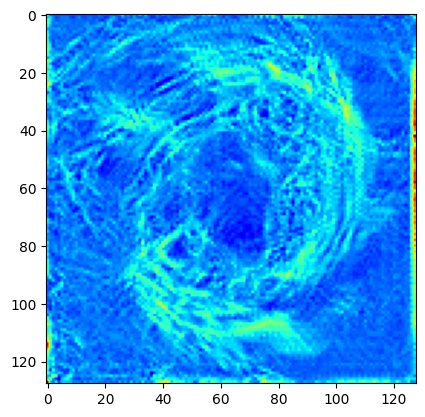

In [21]:
strain = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Archive/strain5/frame_0_strain.npy")
plt.imshow(strain, cmap='jet')

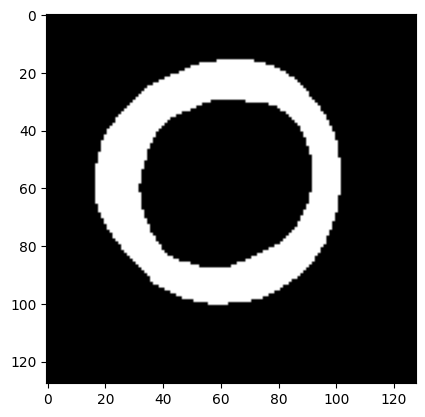

In [7]:
import numpy as np
import matplotlib.pyplot as plt
mask = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/FrameWork/real_test_data/patient_4d_frame_13_mask.npy")
# i want values of mask = 1
mask = mask == 1
plt.imshow(mask, cmap='gray')

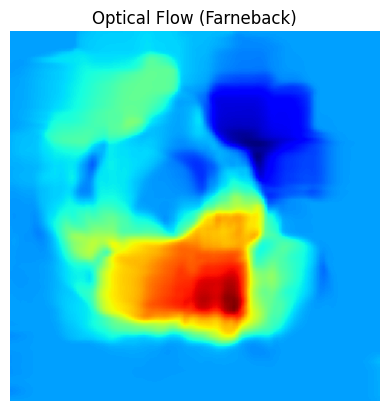

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load two consecutive frames of cardiac cine (grayscale)
frame1 = np.load('/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient096_frame01_slice_3_ACDC_#36_1.npy')
frame2 = np.load('/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient096_frame01_slice_3_ACDC_#36_2.npy')

# Make sure the frames are uint8 for OpenCV
frame1 = frame1.astype(np.uint8)
frame2 = frame2.astype(np.uint8)

# Calculate optical flow
flow = cv2.calcOpticalFlowFarneback(
    prev=frame2, next=frame1, 
    flow=None, pyr_scale=0.5, levels=3, winsize=15, 
    iterations=3, poly_n=5, poly_sigma=1.2, flags=0
)

# Visualize flow as HSV
x_displacement = flow[..., 0]
y_displacement = flow[..., 1]
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
hsv = np.zeros((frame1.shape[0], frame1.shape[1], 3), dtype=np.uint8)
hsv[..., 0] = angle * 180 / np.pi / 2
hsv[..., 1] = 255
hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

plt.imshow(y_displacement, cmap='jet')
plt.title("Optical Flow (Farneback)")
# plt.colorbar()
plt.axis('off')
plt.show()

/opt/homebrew/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['moving_image', 'fixed_image']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


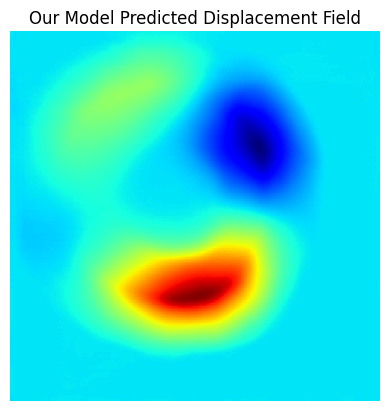

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.layers import Input, concatenate, add, Multiply, Lambda
from keras.models import Model
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Model
from scipy.ndimage import gaussian_filter
from pathlib import Path
import os
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append(os.path.abspath("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Supervised Framework/Models_Arch"))
sys.path.append(os.path.abspath("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Supervised Framework"))
from mask_loss import MaskLoss
from mask_loss import MAELoss
# print(str(Path(__file__).parent))
from ResidualUnet import Residual_Unet
from Unet import Unet
from Unet_7Kernel import Unet_7Kernel
from Unet_5Kernel import Unet_5Kernel
from Unet_3Dense import Unet_3Dense
from Unet_1Dense import Unet_1Dense
from Unet_2Dense import Unet_2Dense
from Unet_1Dense_7Kernel import Unet_1Dense_7Kernel
from Unet_1Dense_5Kernel import Unet_1Dense_5Kernel
from Unet_2Dense_7Kernel import Unet_2Dense_7Kernel
from Unet_2Dense_5Kernel import Unet_2Dense_5Kernel
from Unet_3Dense_7Kernel import Unet_3Dense_7Kernel
from Unet_3Dense_5Kernel import Unet_3Dense_5Kernel
from ResidualUnet_1Dense import Residual_Unet_1D
from ResidualUnet_2Dense import Residual_Unet_2D
from ResidualUnet_3Dense import Residual_Unet_3D
from ResidualUnet_1Dense_7Kernels import Residual_Unet_1D_7K
from ResidualUnet_1Dense_5Kernels import Residual_Unet_1D_5K
from ResidualUnet_2Dense_7Kernels import Residual_Unet_2D_7K
from ResidualUner_2Dense_5Kernels import Residual_Unet_2D_5K
from ResidualUnet_3Dense_7Kernels import Residual_Unet_3D_7K
from ResidualUnet_3Dense_5Kernels import Residual_Unet_3D_5K

def apply_displacement( image, x_displacement, y_displacement):
    # Prepare meshgrid for remap
    height, width = image.shape
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # Apply displacement (scale the displacements for more visible effect)
    x_new = (x + x_displacement).astype(np.float32)
    y_new = (y + y_displacement).astype(np.float32)
    # convert image tensor to numpy
    # image = image.numpy()
    

    # Warp the image using remap for both x and y displacements
    displaced_image = cv2.remap(image, x_new, y_new, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_REFLECT)
    return displaced_image
model = tf.keras.models.load_model("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Best_models/Unet_3Dense_5Kernel_with_mask (1).keras", custom_objects={'MaskLoss': MaskLoss, 'MAELoss': MAELoss, 'Unet_2Dense_5Kernel': Unet_2Dense_5Kernel, 'Residual_Unet': Residual_Unet, 'Unet': Unet, 'Unet_7Kernel': Unet_7Kernel, 'Unet_5Kernel': Unet_5Kernel, 'Unet_3Dense': Unet_3Dense, 'Unet_1Dense': Unet_1Dense, 'Unet_2Dense': Unet_2Dense, 'Unet_1Dense_7Kernel': Unet_1Dense_7Kernel, 'Unet_1Dense_5Kernel': Unet_1Dense_5Kernel, 'Unet_2Dense_7Kernel': Unet_2Dense_7Kernel, 'Unet_2Dense_5Kernel': Unet_2Dense_5Kernel, 'Unet_3Dense_7Kernel': Unet_3Dense_7Kernel, 'Unet_3Dense_5Kernel': Unet_3Dense_5Kernel, 'Residual_Unet_1D': Residual_Unet_1D, 'Residual_Unet_2D': Residual_Unet_2D, 'Residual_Unet_3D': Residual_Unet_3D, 'Residual_Unet_1D_7K': Residual_Unet_1D_7K, 'Residual_Unet_1D_5K': Residual_Unet_1D_5K, 'Residual_Unet_2D_7K': Residual_Unet_2D_7K, 'Residual_Uner_2D_5K': Residual_Unet_2D_5K, 'Residual_Unet_3D_7K': Residual_Unet_3D_7K, 'Residual_Unet_3D_5K': Residual_Unet_3D  })
frame1 = np.load('/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient096_frame01_slice_3_ACDC_#36_1.npy')
frame2 = np.load('/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient096_frame01_slice_3_ACDC_#36_2.npy')

frame1 = frame1.astype(np.float32)
frame2 = frame2.astype(np.float32)
real_moving_image_expanded = tf.expand_dims(frame1, axis=0)
real_fixed_image_expanded = tf.expand_dims(frame2, axis=0)
predicted_deformation_field = model.predict([real_moving_image_expanded, real_fixed_image_expanded])
    
x_disp_map_pred = predicted_deformation_field[0, :, :, 0]
y_disp_map_pred = predicted_deformation_field[0, :, :, 1]
# warp the first frame using the predicted displacement field
warped_frame1_pred = apply_displacement(frame1, x_disp_map_pred, y_disp_map_pred)

plt.imshow(y_disp_map_pred, cmap='jet')
plt.title("Our Model Predicted Displacement Field")
# plt.colorbar()
plt.axis('off')
plt.show()
# Display the results
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.title("Original Frame 1")
# plt.imshow(frame1, cmap='gray')
# plt.subplot(1, 3, 2)
# plt.title("Warped Frame 1 (Predicted)")
# plt.imshow(warped_frame1_pred, cmap='gray')
# plt.subplot(1, 3, 3)        
# plt.title("Target Frame 2")
# plt.imshow(frame2, cmap='gray')
# plt.tight_layout()
# plt.show()

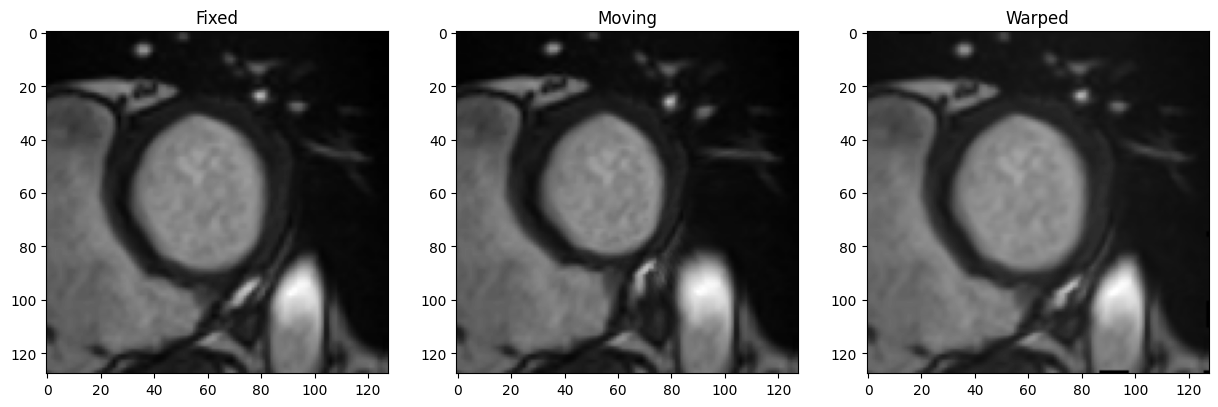

In [3]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Example: two NumPy arrays representing two MRI frames
# Replace with your actual data
fixed_np = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient096_frame01_slice_3_ACDC_#36_1.npy")     # shape: (H, W)
moving_np = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Frames/patient096_frame01_slice_3_ACDC_#36_2.npy")    # shape: (H, W)

# Convert to SimpleITK images (make sure to use Float32 for registration)
fixed_image = sitk.GetImageFromArray(fixed_np.astype(np.float32))
moving_image = sitk.GetImageFromArray(moving_np.astype(np.float32))

# Optionally set image metadata
fixed_image.SetSpacing([1.0, 1.0])
moving_image.SetSpacing([1.0, 1.0])
fixed_image.SetOrigin([0.0, 0.0])
moving_image.SetOrigin([0.0, 0.0])

# Initialize B-spline transform
mesh_size = [10, 10]
initial_transform = sitk.BSplineTransformInitializer(fixed_image, mesh_size)

# Registration setup
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5,
                                         numberOfIterations=100,
                                         maximumNumberOfCorrections=5,
                                         maximumNumberOfFunctionEvaluations=1000,
                                         costFunctionConvergenceFactor=1e+7)
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Run registration
final_transform = registration_method.Execute(fixed_image, moving_image)

# Warp moving image to fixed space
warped_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0)

# Convert warped image to NumPy
warped_np = sitk.GetArrayFromImage(warped_image)

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Fixed")
plt.imshow(fixed_np, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Moving")
plt.imshow(moving_np, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Warped")
plt.imshow(warped_np, cmap='gray')
plt.show()

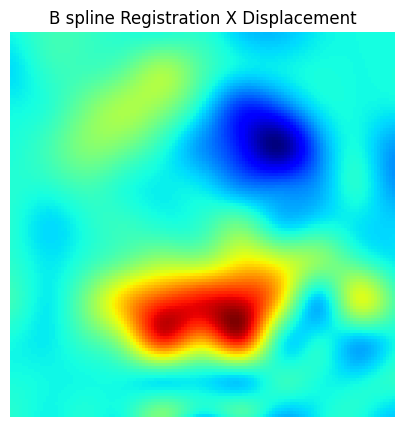

In [13]:
# Get displacement field (as a vector field image)
displacement_field = sitk.TransformToDisplacementField(final_transform, 
                                                       sitk.sitkVectorFloat64, 
                                                       fixed_image.GetSize(), 
                                                       fixed_image.GetOrigin(), 
                                                       fixed_image.GetSpacing(), 
                                                       fixed_image.GetDirection())

# Convert to NumPy: shape = (H, W, 2) for 2D vector field
disp_np = sitk.GetArrayFromImage(displacement_field)  # (H, W, 2)

# Extract X-displacement (index 1 because SimpleITK uses (z,y,x) order)
# For 2D: axis 2 → [0]=Y, [1]=X (row, col)
x_disp = disp_np[..., 1]  # Shape: (H, W)

# Plot X displacement
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
plt.imshow(x_disp*-1, cmap='jet')
# plt.colorbar(label='X Displacement (pixels)')
plt.title("B spline Registration X Displacement")
plt.axis('off')
plt.show()

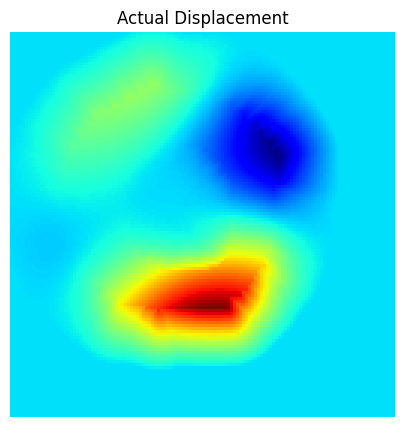

In [14]:
actual_displacement = np.load("/Users/ahmed_ali/Documents/GitHub/GP-2025-Strain/Code/Wave_SimulatorV2/generatedData/Displacements/patient096_frame01_slice_3_ACDC_#36_y.npy")
plt.figure(figsize=(6, 5))
plt.imshow(actual_displacement, cmap='jet')
# plt.colorbar(label='Y Displacement (pixels)')
plt.title("Actual Displacement")
plt.axis('off')
plt.show()